In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model

In [2]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json", "r") as f:
    alldata = json.loads(f.read())

# Train

In [27]:
alldata.keys()

dict_keys(['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST'])

In [28]:
zone = alldata["ISONE CA"]

In [29]:
zone.keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt', 'SYSLoad', 'RegCP'])

In [30]:
slc = 361 * 24
cap = 365 * 24
demand = np.array(zone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(zone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2014 was Wednesday, so starts with 2 (Monday is 0)
days_of_week = [2, 3, 4, 5, 6, 0, 1]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), zone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc)
weekhour = week * hour

In [31]:
temp = np.array(zone["DryBulb"][-(slc + cap):-cap], dtype=np.float64)

In [32]:
temp2 = temp ** 2
temp3 = temp ** 3
tempmonth = temp * month
temp2month = temp2 * month
temp3month = temp3 * month
temphour = temp * hour
temp2hour = temp2 * hour
temp3hour = temp3 * hour

reg = linear_model.LinearRegression()

variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
             temphour, temp2hour, temp3hour]
variables = list(map(list, zip(*variables)))  # transpose
reg.fit(variables, demand)

LinearRegression()

<IPython.core.display.Javascript object>


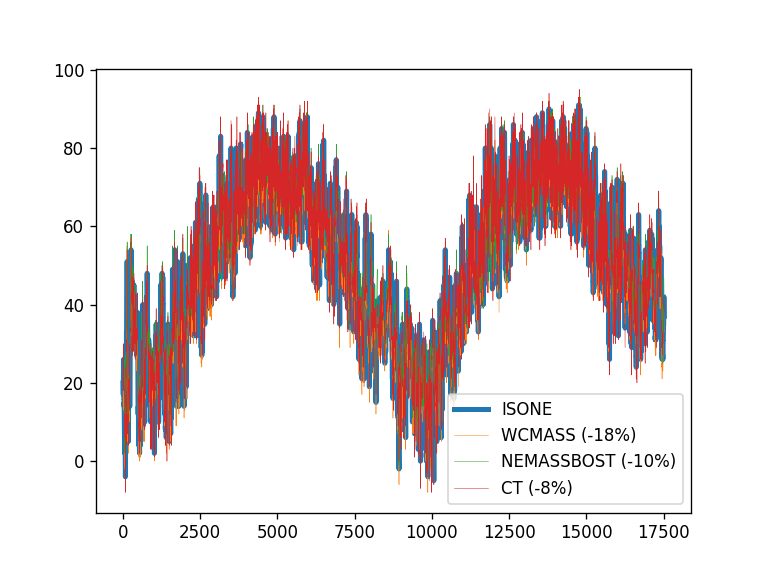

In [33]:
plt.figure()
plt.plot(alldata["ISONE CA"]["DryBulb"][-2*365*24:], linewidth=3)
plt.plot(alldata["WCMASS"]["DryBulb"][-2*365*24:], linewidth=0.3)
plt.plot(alldata["NEMASSBOST"]["DryBulb"][-2*365*24:], linewidth=0.3)
plt.plot(alldata["CT"]["DryBulb"][-2*365*24:], linewidth=0.3)
plt.legend(["ISONE", "WCMASS (-18%)", "NEMASSBOST (-10%)", "CT (-8%)"])
# plt.plot(alldata["WCMASS"]["DryBulb"][-365*24:])
# plt.plot(alldata["NEMASSBOST"]["DryBulb"][-365*24:])
plt.show()

<IPython.core.display.Javascript object>


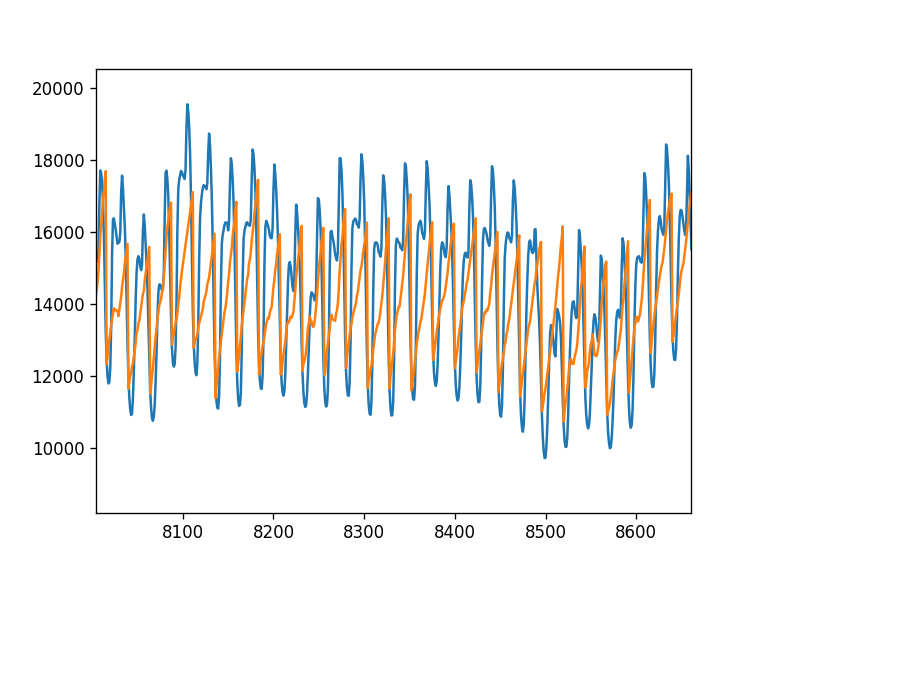

In [41]:
fit = reg.predict(variables)
plt.figure()
plt.plot(demand)
plt.plot(fit)
plt.show()

# Test

In [55]:
slc = 31 * 24
gap = 52 * 24
cap = 365 * 24 - slc - gap
test_demand = np.array(zone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(zone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2015 was Sunday, so starts with 6
days_of_week = [6, 0, 1, 2, 3, 4, 5]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(gap, gap + slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), zone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc, slc + len(demand))

In [56]:
all_temps = np.array(zone["DryBulb"], dtype=np.float64)
temps= []
for year in range(10):
    for shift in range(9):
        offset = int(year * 365.24 + shift + 0.5) * 24
        temps.append(all_temps[offset + gap: offset + slc + gap])

In [57]:
preds = []
for temp in temps:
    weekhour = week * hour
    temp2 = temp ** 2
    temp3 = temp ** 3
    tempmonth = temp * month
    temp2month = temp2 * month
    temp3month = temp3 * month
    temphour = temp * hour
    temp2hour = temp2 * hour
    temp3hour = temp3 * hour
    test_variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
                 temphour, temp2hour, temp3hour]
    test_variables = list(map(list, zip(*test_variables)))  # transpose
    preds.append(reg.predict(test_variables))

In [58]:
preds = np.array(preds)

<IPython.core.display.Javascript object>


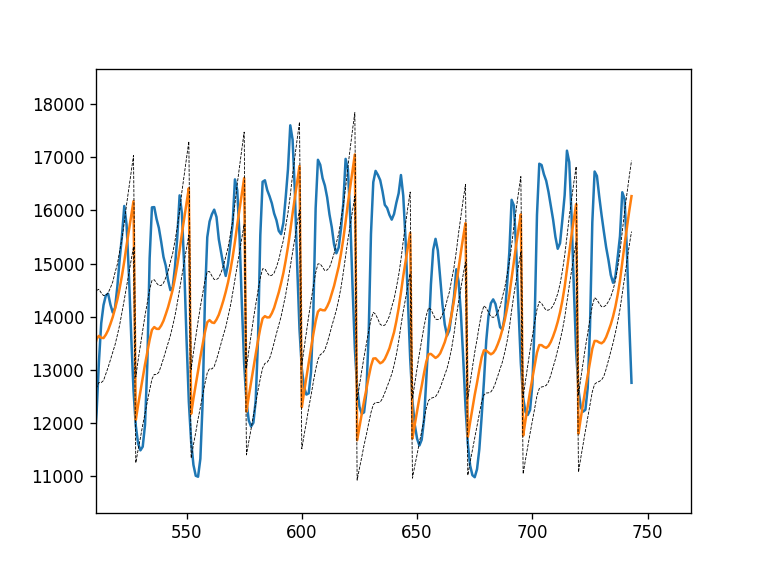

In [59]:
pred = np.mean(preds, axis=0)
std = np.std(preds, axis=0)
plt.figure()
plt.plot(test_demand)
plt.plot(pred)
plt.plot(std + pred, linestyle="--", color="black", linewidth=0.5)
plt.plot(pred - std, linestyle="--", color="black", linewidth=0.5)
plt.show()

In [60]:
def pinball_loss(data, quant_preds, quantiles):
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [61]:
quant_preds = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in range(preds.shape[1]):
    sorted_preds = np.sort(preds[:, t])
    quant_pred = []
    for q in quantiles:
        idx = int(q * preds.shape[0] + 0.5)
        quant_pred.append(sorted_preds[idx])
    quant_preds.append(quant_pred)

In [62]:
print(quant_preds[100])

[13087.274137236946, 13339.957028274179, 13598.658179041682, 13989.940249065996, 14119.388140917312, 14498.35030750393, 14964.56137003711, 15268.808011007877, 15706.682435121398]


In [63]:
pinball_loss(test_demand, quant_preds, quantiles)

587.5824518513574